# DeepSource

This notebook explains that how you can runn deepsource9 to train a CNN on images.

In [1]:
import sys
import glob
import numpy as np
import deepsource as ds

import matplotlib.pylab as plt
from matplotlib import gridspec
from matplotlib.colors import LogNorm
%matplotlib inline

It second notebook, we explained that how you can define a data provider for CNN feeding.

number of files:  4 , number of channels:  1


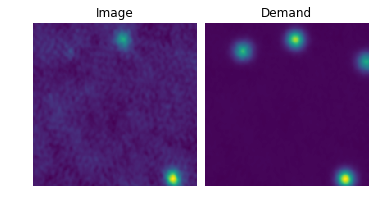

In [2]:
rb = 0
restore=0
patch_size = 200

def kernels(cat):
    out = ds.horn_kernel(cat,radius=10,step_height=2)
    return ds.gaussian_kernel(out,sigma=7)

images_path=['../data/image'+str(i+1)+'.fits' for i in range(4)]
models_path=['../data/image'+str(i+1)+'.txt' for i in range(4)]
ppdp = ds.GeneralDataProvider(images_path=images_path,models_path=models_path,margin=0,
                                     nx=patch_size, ny=patch_size,kernels=kernels, b_n=0.1, alpha=0.3)

x,y = ppdp(1)

gs = gridspec.GridSpec(1, 2)
plt.figure(figsize=(6,3)) 

ax = plt.subplot(gs[0, 0])
ax.imshow(x[0,:,:,0])
ax.set_title('Image')
plt.axis('off')

ax = plt.subplot(gs[0, 1])
ax.imshow(y[0,:,:,0])
ax.set_title('Demand')
plt.axis('off');

plt.subplots_adjust(wspace=0.05)

Then you can use "ppdp" to feed convolutional neural network (CNN). CNN will be trained to transform an image to corresponding demand. "ConvolutionalLayers" class provides a CNN for this purpose. You can easily specify any desired architecture and train/save/restore it. In bellow example there is an architecture defined in file "arch.py" placed in current directory. You can train you CNN using train method:

In [3]:
restore=1

cnn = ds.ConvolutionalLayers(nl=patch_size,learning_rate = 0.001,n_channel=1,
                              restore=restore,model_add='./cmodel',arch_file_name='arch')

cnn.train(ppdp,training_epochs=1,n_s=1, dropout=0.2,verbose=10)

INFO:tensorflow:Restoring parameters from ./cmodel/model


If you want to restore your trained model to use or tue up, you can set the "restore" argument to 1. Then "conv" methos can transform any image to demand:

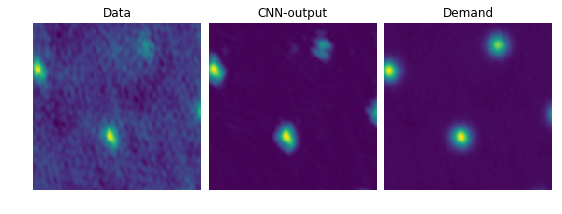

In [4]:
x,y = ppdp(1)
xf = cnn.conv(x)

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(7.5,3.5)) 

ax = plt.subplot(gs[0, 0])
plt.axis('off')
ax.set_title('Data')
ax.imshow(x[0,10:-10,10:-10,0])

ax = plt.subplot(gs[0, 1])
plt.axis('off')
ax.set_title('CNN-output')
ax.imshow(xf[10:-10,10:-10])

ax = plt.subplot(gs[0, 2])
plt.axis('off')
ax.set_title('Demand')
ax.imshow(y[0,10:-10,10:-10,0])

plt.subplots_adjust(wspace=0.05,bottom=0.0, top=0.92, left=0.02, right=0.98)

Now let's transform a whole image and extract point sources from demand map. Since operating on a large image may consume big amount of memory, there is a method to do this job by tiling. 

In [9]:
image_file = '../data/image5.fits'
model_file = '../data/image5.txt'

catalog = ds.ps_extract(image_file,model_file,cnn,ds.fetch_data,loc_det='mean',
                        ignore_border=0,jump_lim=3,area_lim=10,lw=200,pad=10)

47  point sources are found!


0  points are in noisy borders!


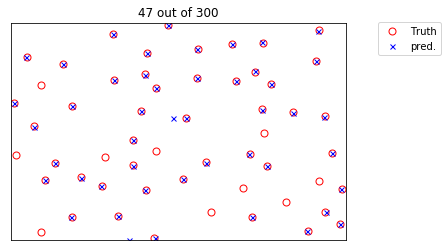

In [10]:
ds.visualize_cross_match(image_file,model_file,catalog)